In [54]:
#%%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras import layers
from datetime import datetime
from pathlib import Path
from scipy import signal
from os import walk
from keras.preprocessing import sequence
from scipy.io import wavfile
import glob
# from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns

import tensorflow as tf

from multiprocessing.dummy import Pool as ThreadPool
import heartpy as hp
import keras
from scipy import fftpack

pool=ThreadPool(24)


In [2]:
log_dir = "/tf/logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
#%tensorboard

In [3]:
# Load wavefile
def readwav(file:str):
    filepath = Path(file).absolute()
    samplerate, data = wavfile.read((filepath))
    # print(f"samplerate = {samplerate}")
    return data,samplerate

In [4]:
def getTiming(data:np.ndarray,samplerate:int):
    length = data.shape[0] / samplerate
    return np.arange(0,length,1/samplerate)



In [5]:
def filterSignal(data:np.ndarray,t:np.ndarray,plot:bool=True,length=None,filter=True):
    ## normalize input
    sig = data/np.amax(data)
    norm_heart = data/np.amax(data)
    sos = signal.butter(1, [.2,195], 'bp', fs=1000, output='sos')
    filtered_heart = signal.sosfilt(sos, sig)
    ## Removing noise
    noise_heart = signal.signaltools.wiener(filtered_heart,300)
    noise_heart = filtered_heart
    if(not filter):
        noise_heart = norm_heart
    if plot:
        
        _, (ax1, ax2,ax3) = plt.subplots(3, 1, sharex=True)
        ax1.plot(t, sig)
        ax1.set_title('Original Heart Rate Signal')
        ax2.plot(t, norm_heart)
        ax2.set_title('After Bandpass filter')
        ax3.plot(t, noise_heart)
        ax3.set_title('After Noise Filter')
        ax3.set_xlabel('Time [seconds]')

        plt.tight_layout()
        plt.show()
    return (noise_heart,t)
    

In [6]:
lengths = []
def generateSignal(file:str,plot:bool=False,loglevel:str=None):
    data,samplerate = readwav(file)
    length = data.shape[0] / samplerate
    lengths.append(length)
    t = getTiming(data,samplerate)

    sig,t = filterSignal(data,t,plot)
    fft = fftpack.fft(sig)
    return t,sig,samplerate,fft

In [7]:
trainingFolder = "./heartbeats/classifications"
trainingpath = Path(trainingFolder)
paths = [Path(dir[0]) for dir in walk(trainingpath)][1:]


In [8]:
train_data = []
# test_data = []
plot = False
def processFiles(indexedWave,classification,trainIndex):
    wav,index = indexedWave

    t,d,samplerate,fft = generateSignal(wav,plot)
    try:
        wd, data = hp.process(d,samplerate)
        points = [data[measure] for measure in data.keys()]
        # if(index < trainIndex):
        train_data.append([classification,d,fft,*points])
    except:
        return
    # else:
        # test_data.append([d,t,classification])


def get_training_data(path:Path):   
    classification = path.name
    wavList = glob.glob(str(path.joinpath("*.wav")))
    trainIndex=int(math.ceil(len(wavList)*.8)) # use 80% of data for training
    pool.map(lambda x: processFiles(x,classification,trainIndex),zip(wavList,range(0,len(wavList))) )
    # for wav in zip(wavList,range(0,len(wavList))):
    #     processFiles(wav,classification,trainIndex)




In [9]:
# Load Data 
#Loading data from this many files is intensive, speeding up w/ multithreading

for path in paths:
    get_training_data(path)
#train_data=np.array(train_data)
#test_data=np.array(test_data)



/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/ma/core.py:5244: RuntimeWarning: Mean of empty slice.
  result = super().mean(axis=axis, dtype=

In [29]:
df = pd.DataFrame(train_data,columns=["classification","signal","fft","bpm","ibi","sdnn","sdsd","rmssd","pnn20","pnn50","hr_mad","sd1","sd2","s","sdr","breathingrate"])
print(df.isna().sum())
df = df.dropna()
# df = df.fillna(df.median())
print(df.isna().sum())

# print(df[["signal","time"]].values)

xs=sequence.pad_sequences(df.signal.values,maxlen=(lambda list: max([len(item) for item in list]))(df.signal.values),dtype="float64")
df.signal = xs
xf=sequence.pad_sequences(df.fft.values,maxlen=(lambda list: max([len(item) for item in list]))(df.fft.values),dtype="float64")
df.fft = xf
# xt=sequence.pad_sequences(df.time.values,maxlen=max_length,dtype="float64")

# y = df.iloc
# sequence.pad_sequences(df[["signal","time"]].values,maxlen=max_length,dtype="float64")
# print(df.iloc[2])
df = pd.get_dummies(df,columns=["classification"])



classification     0
signal             0
fft                0
bpm               37
ibi               37
sdnn              37
sdsd               0
rmssd             52
pnn20             52
pnn50             52
hr_mad            37
sd1               52
sd2               52
s                 52
sdr               69
breathingrate     68
dtype: int64
classification    0
signal            0
fft               0
bpm               0
ibi               0
sdnn              0
sdsd              0
rmssd             0
pnn20             0
pnn50             0
hr_mad            0
sd1               0
sd2               0
s                 0
sdr               0
breathingrate     0
dtype: int64


/usr/local/lib/python3.8/dist-packages/keras_preprocessing/sequence.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  trunc = np.asarray(trunc, dtype=dtype)


In [34]:
norm = lambda df: (df-df.min())/(df.max()-df.min())
x = np.array(df.iloc[:,2:14].values,dtype=np.float64)
x = np.nan_to_num(np.array(norm(x),dtype=np.float64))
y = df.iloc[:,15:]
x.shape

(87, 12)

In [31]:
print(x.shape)
# y=tf.keras.utils.to_categorical(np.array(y),num_classes=5)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

(87, 12)


In [37]:
# define model
# strategy = tf.distribute.MirroredStrategy()
# with strategy.scope():
model = Sequential()
model.add(layers.Normalization(axis=-1, input_dim=12))
model.add(layers.Dense(512, activation="selu"))
model.add(layers.Dense(256, activation='selu'))
model.add(layers.Dense(128, activation='selu'))

model.add(layers.Dense(5, activation="softmax"))
print(model.summary())
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 12)               25        
 ion)                                                            
                                                                 
 dense_20 (Dense)            (None, 512)               6656      
                                                                 
 dense_21 (Dense)            (None, 256)               131328    
                                                                 
 dense_22 (Dense)            (None, 128)               32896     
                                                                 
 dense_23 (Dense)            (None, 5)                 645       
                                                                 
Total params: 171,550
Trainable params: 171,525
Non-trainable params: 25
_______________________________________________

In [47]:
history = model.fit(x_train, y_train, epochs=10, batch_size=1, validation_data=(x_test,y_test))


Epoch 1/1000
78/78 [==============================] - 1s 11ms/step - loss: 0.9700 - accuracy: 0.5641 - val_loss: 1.2873 - val_accuracy: 0.3333
Epoch 2/1000
78/78 [==============================] - 1s 9ms/step - loss: 0.9966 - accuracy: 0.5256 - val_loss: 1.2103 - val_accuracy: 0.4444
Epoch 3/1000
78/78 [==============================] - 1s 9ms/step - loss: 0.9661 - accuracy: 0.5769 - val_loss: 1.1351 - val_accuracy: 0.5556
Epoch 4/1000
78/78 [==============================] - 1s 9ms/step - loss: 0.9996 - accuracy: 0.5513 - val_loss: 1.0443 - val_accuracy: 0.6667
Epoch 5/1000
78/78 [==============================] - 1s 9ms/step - loss: 0.9933 - accuracy: 0.4744 - val_loss: 1.0444 - val_accuracy: 0.6667
Epoch 6/1000
78/78 [==============================] - 1s 9ms/step - loss: 1.1055 - accuracy: 0.5000 - val_loss: 1.4159 - val_accuracy: 0.4444
Epoch 7/1000
78/78 [==============================] - 1s 9ms/step - loss: 1.2485 - accuracy: 0.4615 - val_loss: 1.1502 - val_accuracy: 0.5556
Epoch

In [42]:
scores = model.evaluate(x_test, y_test, verbose=0)
print(scores)
m, s = np.mean(scores), np.std(scores)
print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

[1.1391031742095947, 0.4444444477558136]
Accuracy: 0.792% (+/-0.347)


In [49]:
predictions = model.predict(x_test)

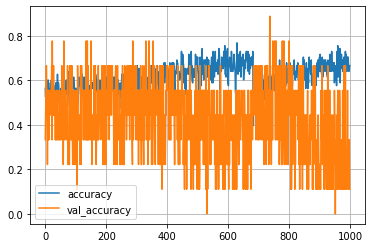

In [51]:
def plot_loss(history):
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label='val_accuracy')
  plt.legend()
  plt.grid(True)
plot_loss(history)

In [55]:
sns.pairplot(df[2:14], kind="scatter")
